In [1]:
import sys  
sys.path.append('/home/ross/CardiffCovidBiomarkers')
import sqlite3 as sql
from data_loader import *
from statistics_utils import *
from box_swarm_plots import *
con = sql.connect("/home/ross/CHADBuilder/CHAD.db")

In [2]:
# Data wrangling
from warnings import warn
from multiprocessing import Pool, cpu_count
from statsmodels.stats.multitest import multipletests
from functools import partial, reduce
from scipy import stats
from tqdm.notebook import tqdm
import sqlite3 as sql
import pandas as pd
import numpy as np
import re
# Data Viz
from matplotlib.lines import Line2D
from matplotlib.axes import Axes
from matplotlib.dates import DateFormatter
from matplotlib import lines
import matplotlib.markers as mmark
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
sns.set(style="white", font_scale=1.2)
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

<h1>Introduction and research question</h1>

<h1>Generating a patient cohort</h1>

<h2>Loading the dataset</h2>

The utility functions in `data_loader.py` handle the generation of data from CHAD. We start by loading the events table and the positive COVID-19 PCR results.

In [4]:
events = load_events(con=con, start_date="01/01/2020")
covid_results = load_covid_results(con=con)

We can then use the functions `eu_admissions` to filter the events for each patient and `label_endpoint` to create a label for endpoints of interest like 28 day mortality and ICU admission. Finally, we append the relevant pathology results within a designated timeframe using the `append_pathology` function. See `data_loader` module for documentation.

This code will select all COVID-19 positive individuals, with a positive PCR result within 14 days prior to ED attendance or 7 days after, and were subsequently admitted to hospital within 48 hours of their ED attendance.

In [5]:
pt_events = [x[1] for x in events.groupby("patient_id")]
with Pool(cpu_count()) as pool:
    print("--------------------------------")
    print("Fetch COVID-19 positive ED admissions...")
    func = partial(eu_admissions,
                   attendance_only=False,
                   first_record_only=True,
                   admission_window=48,
                   covid_results=covid_results,
                   covid_positivity_window=(14, 7))
    covid_admissions = list(tqdm(pool.imap(func, pt_events),
                                 total=len(pt_events)))
    covid_admissions = [x for x in covid_admissions if x.shape[0] > 0]
    print("Label with 28 day mortality and/or ICU admission...")
    func = partial(label_endpoint,
                   events=events,
                   endpoint=dict(death="1", critical_care="Y"),
                   timelimit=28)
    endpoints = list(tqdm(pool.imap(func, covid_admissions),
                          total=len(covid_admissions)))
    for ep, event in zip(endpoints, covid_admissions):
        for k, v in ep.items():
            event[k] = v
    print("Append pathology results...")
    path = load_pathology(con=con,
                          patient_ids=[x.patient_id for x in covid_admissions])
    func = partial(append_pathology,
                   pathology=path,
                   time_window=(48, 72))
    covid_admissions = list(tqdm(pool.imap(func, covid_admissions),
                                 total=len(covid_admissions)))
    covid_admissions = pd.concat(covid_admissions)
    print("Merge with demographic data...")
    demos = load_demographics(con=con, patient_ids = covid_admissions.patient_id.values)
    covid_admissions = covid_admissions.merge(demos, on="patient_id")
    print("Complete!")
    print("--------------------------------")

--------------------------------
Fetch COVID-19 positive ED admissions...



Label with 28 day mortality and/or ICU admission...



Append pathology results...



Merge with demographic data...
Complete!
--------------------------------


For the purpose of this study, we will only include patients above the age of 18 years:

In [6]:
covid_admissions = covid_admissions[covid_admissions.age >= 18]

<h2>When did the extended COVID-19 panel come into regular use?</h2>

We're interested in studying the 5 biomarkers introduced during the COVID-19 pandemic:

* High Sensitivity Troponin I
* Lactate dehydrogenase
* Ferritin
* Procalcitonin
* D-dimer

So when were these tests introduced? We need to know this to limit our cohort to a relevant population.

In [10]:
# Pull pathology data for 5 biomarkers of interest
q = """SELECT patient_id, test_name, collection_datetime FROM Pathology 
WHERE test_name IN ('High Sensitivity Troponin I', 'Lactate dehydrogenase',
'Ferritin', 'Procalcitonin', 'D-dimer')"""
path = pd.read_sql(q, con=con)
# Get EU events
q = """SELECT patient_id, event_datetime FROM Events WHERE component == 'EU';"""
eu = pd.read_sql(q, con=con)
# Process datetime for queries
path["collection_datetime"] = pd.to_datetime(path.collection_datetime).dt.tz_localize(None)
eu["event_datetime"] = pd.to_datetime(eu.event_datetime).dt.tz_localize(None)
# Merge the emergency unit events and pathology results
path_events = path.merge(eu, on="patient_id")
# Filter pathology results in EU to those generate on the date of EU attendance or within 3 days of this date
eu_pathology = path_events[(path_events.collection_datetime >= path_events.event_datetime) & 
                           (path_events.collection_datetime <= 
                            (path_events.event_datetime + np.timedelta64(3, "D")))]
# Wrangle ready for plotting
eu_pathology = pd.DataFrame(eu_pathology
                            .drop("event_datetime", axis=1)
                            .groupby(["collection_datetime", "test_name"])
                            .agg(len)).reset_index().rename({"patient_id": "Count"}, axis=1)
# Convert to weekly sums
path_weekly = (eu_pathology.groupby(["test_name", 
                                     pd.Grouper(key="collection_datetime", 
                                                freq="W")])["Count"]
               .sum()
               .reset_index()
               .sort_values("collection_datetime"))
path_weekly["collection_datetime"] = path_weekly["collection_datetime"].dt.tz_localize(None)
# Drop the last week 6th July
path_weekly = path_weekly[path_weekly.collection_datetime != path_weekly.collection_datetime.max()]

In [15]:
# Get daily EU C19 admissions
x = covid_admissions.copy()
x = x[["patient_id", "event_datetime"]].drop_duplicates()
x["event_datetime"] = pd.to_datetime(x["event_datetime"]) 
x["event_date"] = pd.to_datetime(x["event_datetime"].dt.date)
x.drop("event_datetime", axis=1, inplace=True)
x = (pd.DataFrame(x.groupby(pd.Grouper(key="event_date", freq="W"))
                  .agg(len))
     .reset_index()
     .rename({"patient_id": "Count"}, axis=1))

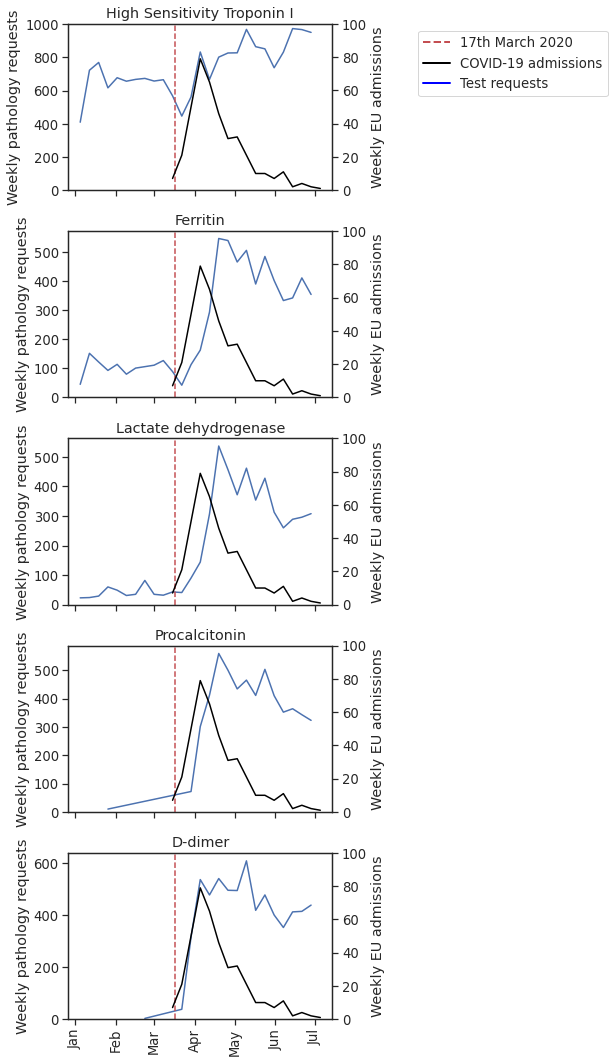

In [20]:
# Plot 
fig, axes = plt.subplots(5, 1, figsize=(10, 15), sharex=True)
date_form = DateFormatter("%b")
for i, marker in enumerate(path_weekly.test_name.unique()):
    mdf = path_weekly[path_weekly.test_name == marker]
    sns.lineplot(x="collection_datetime", y="Count", data=mdf, ax=axes[i])
    ax2 = axes[i].twinx()
    sns.lineplot(x="event_date", y="Count",
                 data=x, ax=ax2, color="black", linestyle="--")
    plt.setp(axes[i].get_xticklabels(), rotation=90)
    axes[i].set_xlabel("")
    axes[i].xaxis.set_major_formatter(date_form)
    axes[i].axvline(pd.to_datetime("17/03/2020", format="%d/%m/%Y"), c="r", ls="--")
    axes[i].set_title(marker)
    axes[i].set_ylabel("Weekly pathology requests")
    axes[i].set_ylim(0)
    ax2.set_ylabel("Weekly EU admissions")
    ax2.set_ylim(0, 100)
handles = [lines.Line2D((0, 1), (0, 0), lw=2, ls="--", c="r"),
lines.Line2D((0, 1), (0, 0), lw=2, ls="-", c="black"),
lines.Line2D((0, 1), (0, 0), lw=2, ls="-", c="blue"),]
axes[0].legend(handles=handles, labels=["17th March 2020", "COVID-19 admissions", "Test requests"],
               bbox_to_anchor=(1.3, 1), loc='upper left')
fig.tight_layout()
plt.savefig("../figures/EURequest.svg", facecolor="white")
plt.show()

After observing the above, we decided to only include those events from the 17th of March onwards:

In [21]:
dt = pd.to_datetime("17/03/2020", format="%d/%m/%Y")
covid_admissions = covid_admissions[covid_admissions.event_datetime >= dt]

<h2>Cleaning up the data</h2>

Some cleaning has been done already (such as removal of greater than or less than signs) but there are still null values and string values in the `test_result` column:

In [22]:
print(f"Null values: {covid_admissions.test_result.isnull().sum()}")
print(f"String values: {sum(covid_admissions.test_result.apply(lambda x: type(x) == str))}")

Null values: 1175
String values: 114


In [23]:
# Remove missing test results
covid_admissions = covid_admissions[~pd.isnull(covid_admissions.test_result)]

All the string values belong to the blood grouping test or COVID-19 Antibody test:

In [24]:
(covid_admissions[covid_admissions.test_result.apply(lambda x: type(x) == str)]
 .test_category
 .unique())

array(['ABG'], dtype=object)

We'll convert the blood grouping to a separate column:

In [25]:
covid_admissions = covid_admissions[covid_admissions.test_category != "ABG"]

In [26]:
pt_ids = covid_admissions.patient_id.unique()
q = "SELECT * FROM Pathology WHERE test_name='ABG' AND patient_id IN (" + ",".join("?" * len(pt_ids)) + ");"
abg = pd.read_sql(q, con=con, params=pt_ids)[["patient_id", "test_result"]]

How many patients have a blood grouping result?

In [27]:
len(covid_admissions.merge(abg, on="patient_id").patient_id.unique())

239

In [28]:
239/len(covid_admissions.patient_id.unique())

0.6128205128205129

So around 60% of patients have a blood group on record in this cohort. We'll merge the blood group data and a this info will be contained in a new column named `blood_group`

In [29]:
covid_admissions = (covid_admissions
                    .merge(abg.rename({"test_result": "blood_group"}, axis=1), 
                           on="patient_id", how="left"))

<h2>Take the first observation for each test for each patient</h2>

Some patients will of course receive multiple test results during their stay. We are interested in admission biomarkers for triaging at the front door, so we will only include the first available result.

In [30]:
def first_pathology_result(df: pd.DataFrame):
    return df.sort_values("collection_datetime").iloc[0]

covid_admissions = (covid_admissions
                    .groupby(["patient_id", "test_name"])
                    .apply(first_pathology_result)
                    .drop(["test_name", "patient_id"], axis=1)
                    .reset_index())

In [31]:
covid_admissions.shape

(14518, 16)

We can now drop some redundant columns:

In [32]:
covid_admissions = covid_admissions.drop(["component", "event_type", "test_category"], axis=1)

<h2>Engineer additional variables</h2>

For now we are going to introduce two additional variables: Neutrophil to Lymphocyte ratio and age groups

In [33]:
lymph_count = (covid_admissions[covid_admissions.test_name == "Lymphocyte count"]
              [["patient_id", "test_result", "collection_datetime"]]
               .rename({"test_result": "lymph_count"}, axis=1))
neutro_count = (covid_admissions[covid_admissions.test_name == "Neutrophil count"]
              [["patient_id", "test_result", "collection_datetime"]]
                .rename({"test_result": "neutro_count"}, axis=1))
neutro_lymph = lymph_count.merge(neutro_count, on=["patient_id", "collection_datetime"])

In [34]:
neutro_lymph.head()

patient_id  lymph_count collection_datetime  neutro_count
0   10090271          1.0 2020-06-05 15:10:00          10.1
1   10090361          1.1 2020-03-28 11:50:00           3.5
2   10090870          0.5 2020-05-03 00:00:00           6.5
3   10091329          0.9 2020-03-26 16:40:00           2.7
4   10091936          0.5 2020-04-27 13:15:00           4.7

We've merged the lymphocyte and neutrophil counts so that we can get the values obtained with the same collection date and time. Now we can calculate the ratio:

In [22]:
neutro_lymph["Neutrophils:Lymphocytes"] = neutro_lymph["neutro_count"]/neutro_lymph["lymph_count"]

Then we drop redundant columns and wrangle it into a single row for this variable:

In [23]:
neutro_lymph = neutro_lymph.drop(["lymph_count", "neutro_count"], axis=1)
neutro_lymph = neutro_lymph.melt(id_vars=["patient_id", "collection_datetime"], 
                                 var_name="test_name", 
                                 value_name="test_result")

In [24]:
neutro_lymph.head()

patient_id collection_datetime                test_name  test_result
0   10090271 2020-06-05 15:10:00  Neutrophils:Lymphocytes    10.100000
1   10090361 2020-03-28 11:50:00  Neutrophils:Lymphocytes     3.181818
2   10090870 2020-05-03 00:00:00  Neutrophils:Lymphocytes    13.000000
3   10091329 2020-03-26 16:40:00  Neutrophils:Lymphocytes     3.000000
4   10091936 2020-04-27 13:15:00  Neutrophils:Lymphocytes     9.400000

We now need to just do some additional wrangling to get this data back into our original dataframe:

In [29]:
neutro_lymph["test_datetime"] = neutro_lymph["collection_datetime"]
cols = [x for x in covid_admissions.columns if x not in ["test_name", "test_result", 
                                                         "collection_datetime",
                                                         "test_datetime"]]
neutro_lymph = neutro_lymph.merge(covid_admissions[cols], on="patient_id").drop_duplicates()

In [32]:
covid_admissions = pd.concat([covid_admissions, neutro_lymph], sort=False)

Let's categorise the age for later:

In [33]:
def group_age(x):
    if x <= 50:
        return "<=50"
    if x >=51 and x <=65:
        return "51-65"
    if x >= 66 and x <=75:
        return "66-75"
    if x >= 76 and x <= 85:
        return "76-85"
    return ">86"
covid_admissions["age_groups"] = covid_admissions.age.apply(group_age)
covid_admissions["age_groups"] = pd.Categorical(values=covid_admissions.age_groups,
                                                categories=["<=50", 
                                                            "51-65", "66-75", 
                                                            "76-85", ">86"])

Finally, we just need to create our composite score for 28 day mortality OR ICU admission:

In [37]:
covid_admissions["composite"] = covid_admissions["death"] | covid_admissions["critical_care"]

In [39]:
covid_admissions.to_csv("../covid_admissions.csv", index=False)

<h1>Describe this cohort and univariate statistics for biomarkers of clinical interest</h1>

In [35]:
covid_admissions = pd.read_csv("../covid_admissions.csv")

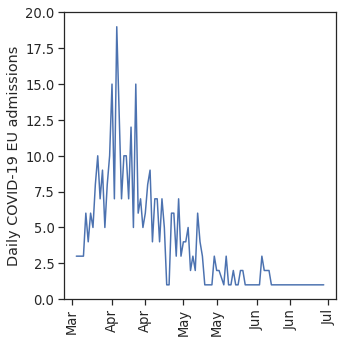

In [44]:
# Plot the number of admissions over time
x = covid_admissions[["patient_id", "event_datetime"]].drop_duplicates()
x["event_datetime"] = pd.to_datetime(x["event_datetime"]) 
x["event_date"] = pd.to_datetime(x["event_datetime"].dt.date)
x.drop("event_datetime", axis=1, inplace=True)
x = (pd.DataFrame(x.groupby(["event_date"])
                  .agg(len))
     .reset_index()
     .rename({"patient_id": "Count"}, axis=1))
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.lineplot(x="event_date", y="Count", data=x)
ax.set_xlabel("")
ax.set_ylabel("Daily COVID-19 EU admissions")
ax.set_ylim((0, 20))
plt.xticks(rotation=90)
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)
fig.tight_layout()
fig.savefig("../figures/covid_daily_admissions.svg", facecolor="white")
plt.show()

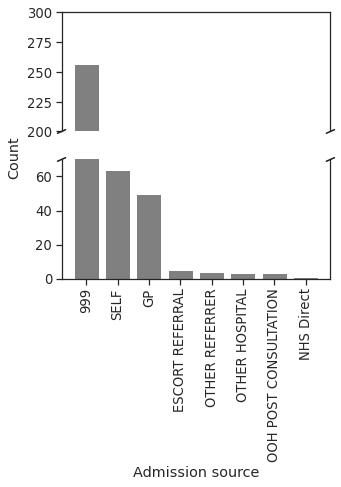

In [45]:
# Plot source
x = pd.DataFrame(covid_admissions[["patient_id", "source"]].drop_duplicates()["source"].value_counts())
x = x.reset_index().rename({"index": "Source", "source": "Count"}, axis=1)

f,(ax,ax2) = plt.subplots(2,1,sharex=True, figsize=(5,7))
ax = sns.barplot(x=x.Source, y=x.Count, ax=ax, color="grey")
ax2 = sns.barplot(x=x.Source, y=x.Count, ax=ax2, color="grey")
ax.set_ylim(200, 300) # outliers only
ax2.set_ylim(0, 70) # most of the data

ax.set_xticklabels([])
ax.set_xlabel("")
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_ticks_position('none') 
ax2.spines['top'].set_visible(False)
ax2.xaxis.tick_bottom()

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d,+d),(-d,+d), **kwargs)      # top-left diagonal
ax.plot((1-d,1+d),(-d,+d), **kwargs)    # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d),(1-d,1+d), **kwargs)   # bottom-left diagonal
ax2.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-right diagonal
ax.set_ylabel("")
ax2.set_xlabel("Admission source")
ax2.yaxis.set_label_coords(-0.15,1.02)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
f.tight_layout()
f.savefig("../figures/covid_admission_source", facecolor="white")
plt.show()

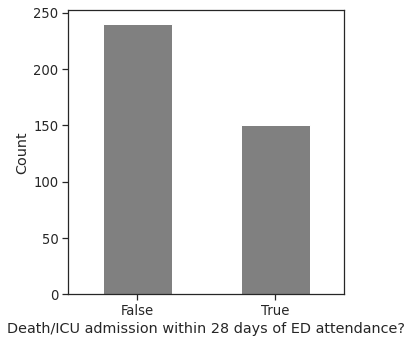

In [46]:
# Plot deaths/icu admissions
fig, ax = plt.subplots(figsize=(5,5))
ax = (covid_admissions[["patient_id", "composite"]]
 .drop_duplicates()
 ["composite"].value_counts()).plot(kind="bar", color="grey", ax=ax)
ax.set_ylabel("Count")
ax.set_xlabel("Death/ICU admission within 28 days of ED attendance?")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
fig.tight_layout()
fig.savefig("../figures/death_icu_count.svg", facecolor="white", bbox_inches = "tight")
plt.show()

In [48]:
(covid_admissions[["patient_id", "composite"]]
 .drop_duplicates()["composite"]
 .value_counts())

False    240
True     150
Name: composite, dtype: int64

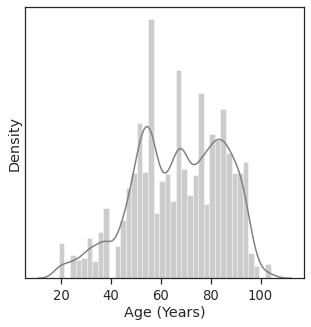

In [50]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(covid_admissions["age"], color="grey")
ax.set_xlabel("Age (Years)")
ax.set_yticks([])
ax.set_ylabel("Density")
fig.savefig("../figures/age_dist.svg", facecolor="white")
plt.show()

0.0027382491687229235


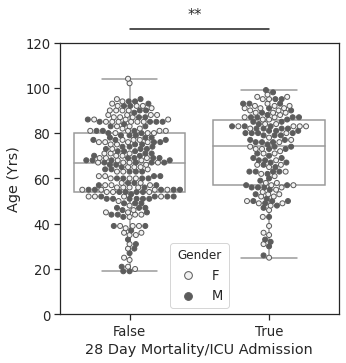

In [4]:
fig, ax = plt.subplots(figsize=(5,5))
box_swarm(covid_admissions, "composite", "age", "gender",
          "28 Day Mortality/ICU Admission", "Age (Yrs)",
          legend_title="Gender", wide=False, ax=ax, ylim=(0, 120))
fig.savefig("../figures/age_composite.svg", facecolor="white", bbox_inches = "tight")
plt.show()

3.685652671729311e-14


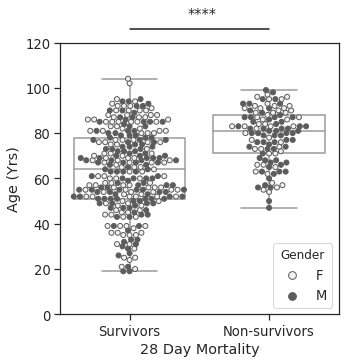

In [5]:
fig, ax = plt.subplots(figsize=(5,5))
box_swarm(df=covid_admissions, x="death", y="age", marker_fill="gender",
          xlabel="28 Day Mortality", ylabel="Age (Yrs)", 
          xticklabels=["Survivors", "Non-survivors"],
          legend_title="Gender", wide=False, ylim=(0,120), ax=ax)
fig.savefig("../figures/age_mortality.svg", facecolor="white", bbox_inches = "tight")
plt.show()

3.685652671729311e-14


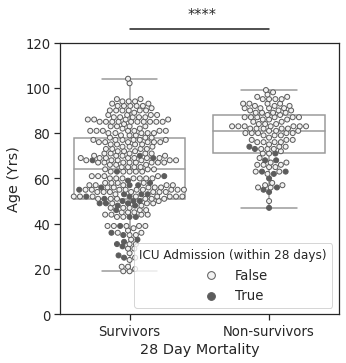

In [6]:
fig, ax = plt.subplots(figsize=(5,5))
box_swarm(covid_admissions, "death", "age", "critical_care",
          "28 Day Mortality", "Age (Yrs)", (0,120), ["Survivors", "Non-survivors"],
          legend_title="ICU Admission (within 28 days)", wide=False)
fig.savefig("../figures/age_mortality_fill_icu.svg", facecolor="white", bbox_inches = "tight")
plt.show()

0.006294966235253231


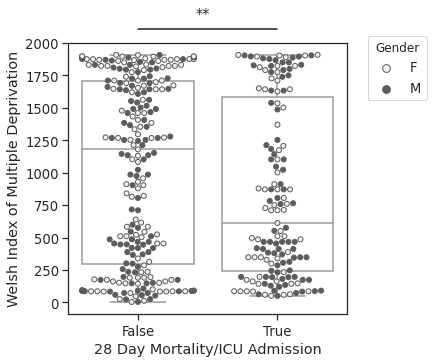

In [7]:
fig, ax = plt.subplots(figsize=(5,5))
box_swarm(covid_admissions, "composite", "wimd", "gender",
          "28 Day Mortality/ICU Admission", "Welsh Index of Multiple Deprivation",
          legend_title="Gender", wide=False, legend_pos=(1.05, 1.05))
fig.savefig("../figures/wimd_composite.svg", facecolor="white", bbox_inches = "tight")
plt.show()

0.2103163118935852


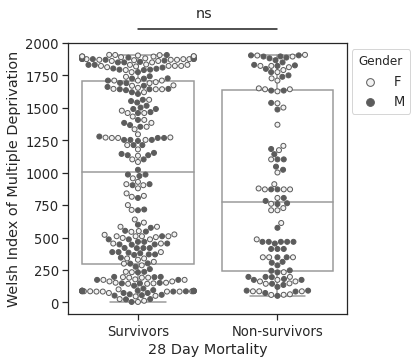

In [8]:
fig, ax = plt.subplots(figsize=(5,5))
box_swarm(covid_admissions, "death", "wimd", "gender",
          "28 Day Mortality", "Welsh Index of Multiple Deprivation", 
          xticklabels=["Survivors", "Non-survivors"],
          legend_title="Gender", wide=False, legend_pos=(1.25, 1.), ax=ax)
fig.savefig("../figures/wimd_mortality.svg", facecolor="white", bbox_inches = "tight")
plt.show()

<h2>Categorise the WIMD variable</h2>

<AxesSubplot:ylabel='Frequency'>

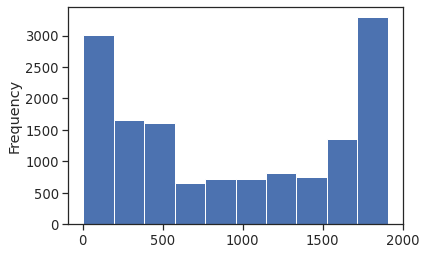

In [10]:
covid_admissions["wimd"].plot(kind="hist")

In [9]:
covid_admissions["wimd_quartiles"] = pd.qcut(covid_admissions.wimd, q=4, 
                                            labels=["Q1 (<246)", "Q2 (246-870)",
                                                     "Q3 (872-1672)", "Q4 (>1672)"])

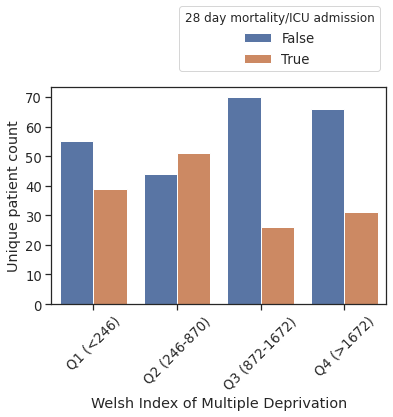

In [13]:
x = covid_admissions[["patient_id", "wimd_quartiles", "composite"]].drop_duplicates()
x = x.groupby(["wimd_quartiles", "composite"]).agg(len).reset_index()
ax = sns.barplot(x="wimd_quartiles", y="patient_id", hue="composite", data=x)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel("Welsh Index of Multiple Deprivation")
ax.set_ylabel("Unique patient count")
l = ax.get_legend()
l.set_title("28 day mortality/ICU admission")
l.set_bbox_to_anchor((1., 1.4))
plt.savefig("../figures/wimd_quantiles.svg", facecolor="white", bbox_inches = "tight")
plt.show()

In [14]:
covid_admissions.to_csv("covid_admissions.csv", index=False)

<h2>Univariate statistics for clinically interesting biomarkers</h2>

The code below generates boxplots in the `boxplots` folder located in the `figures` folder.

/home/ross/CHADBiomarkers/box_swarm_plots.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figsize=(13, 6))


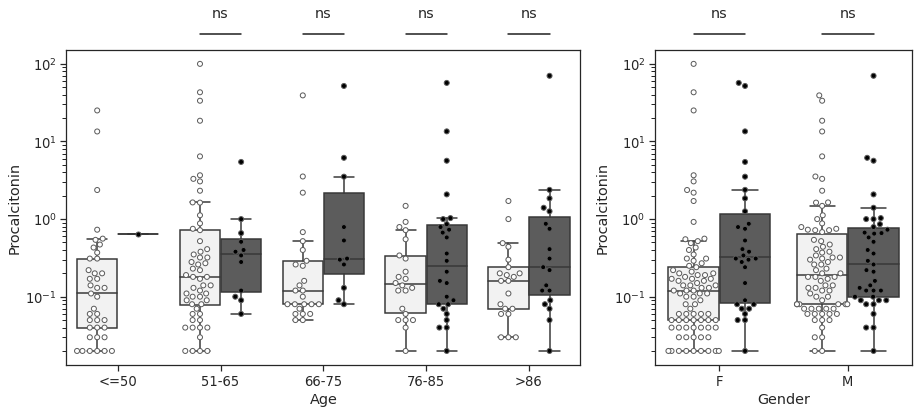

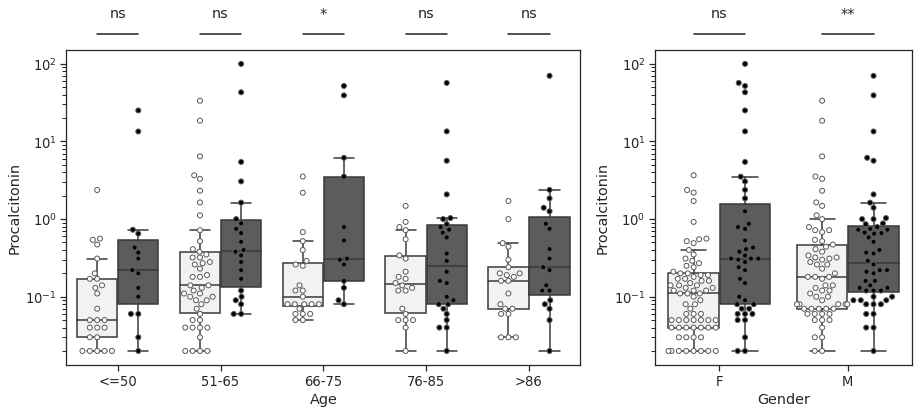

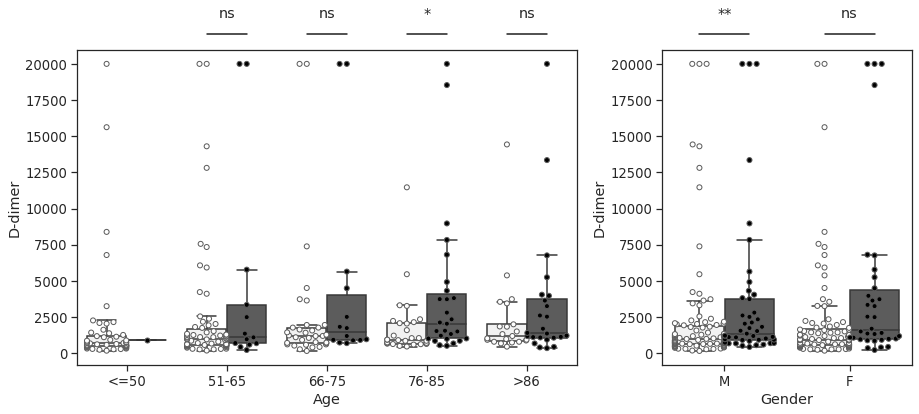

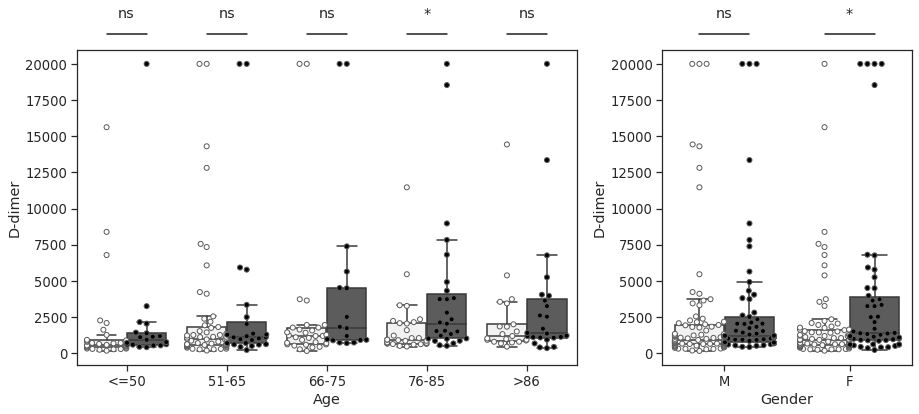

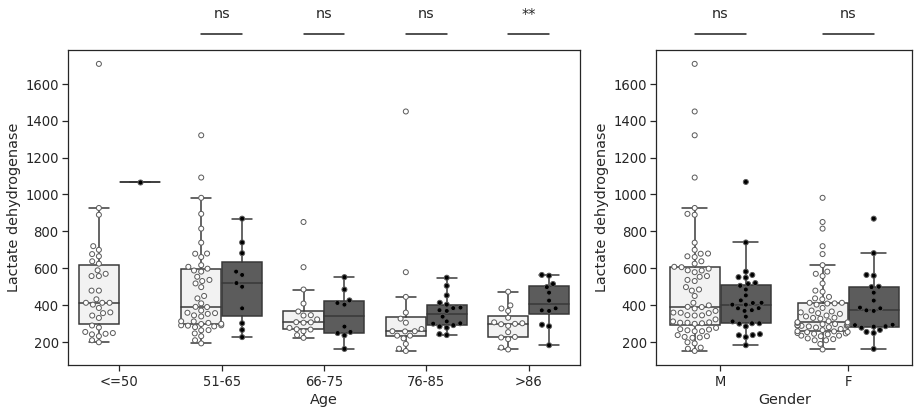

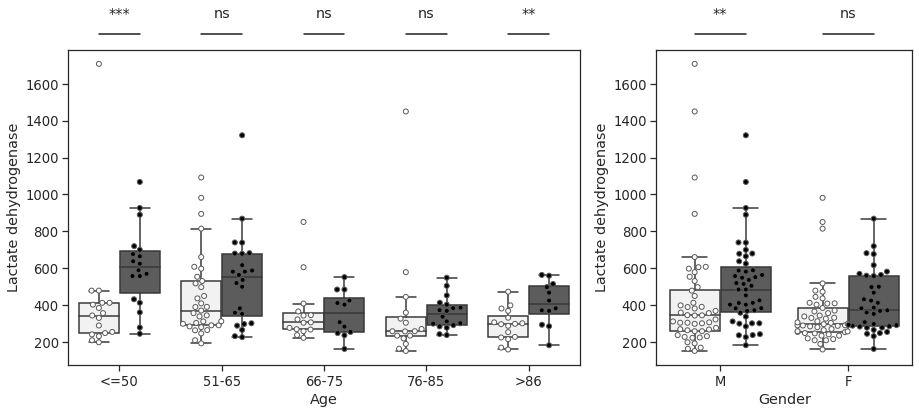

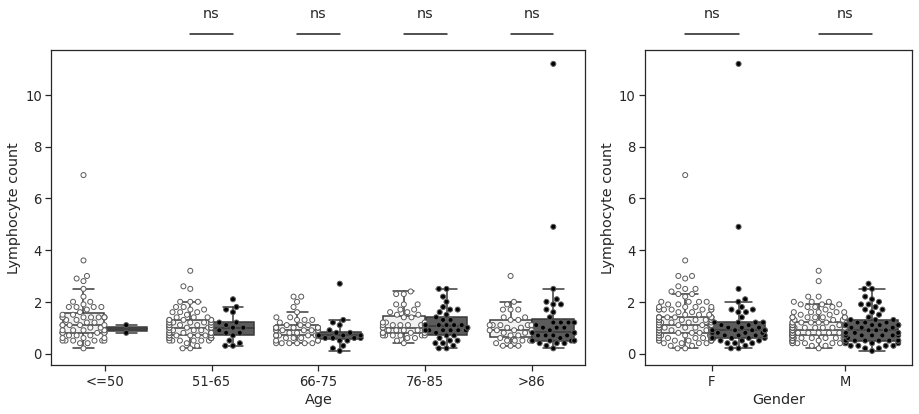

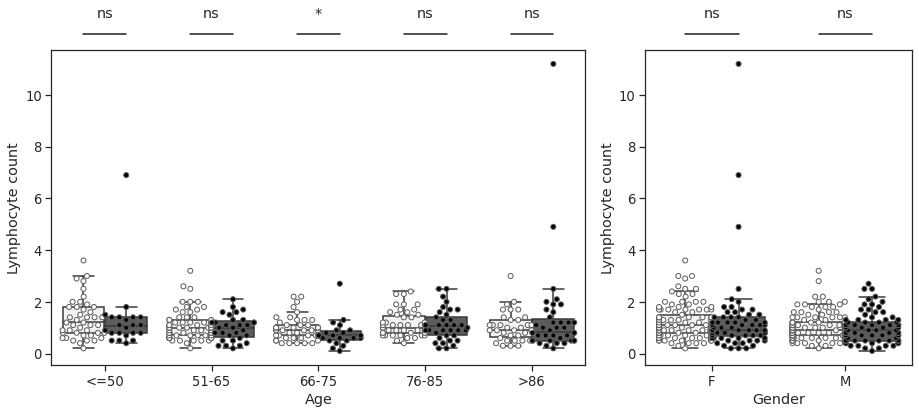

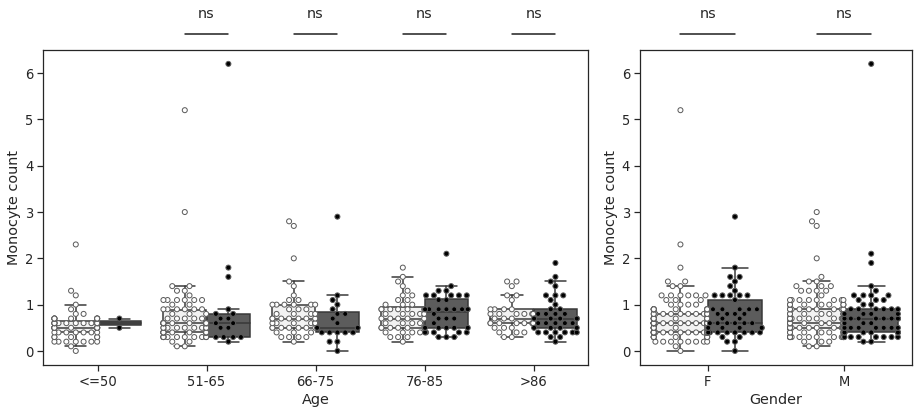

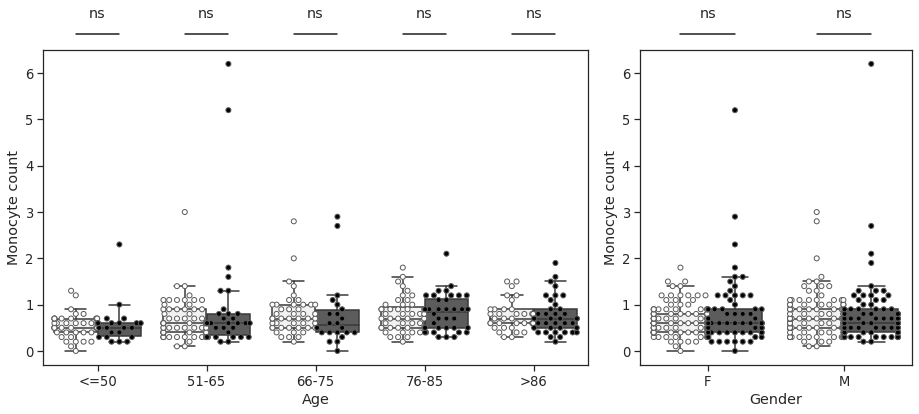

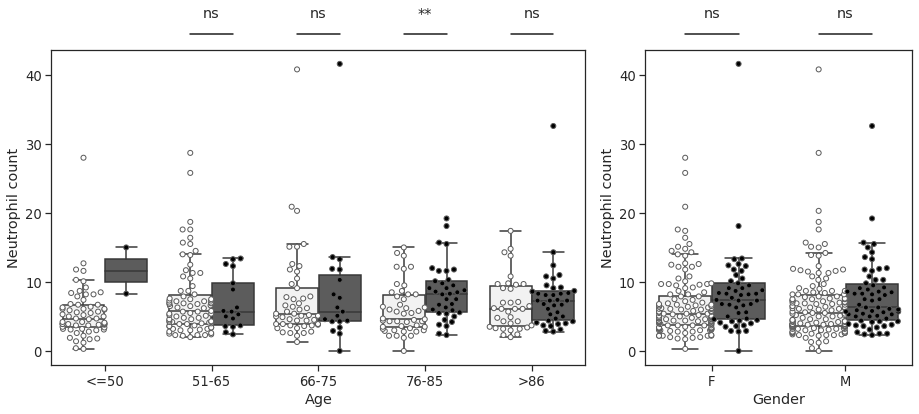

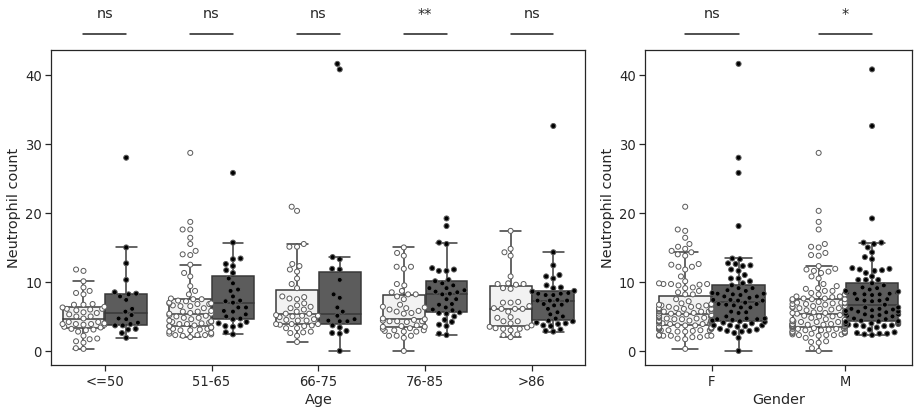

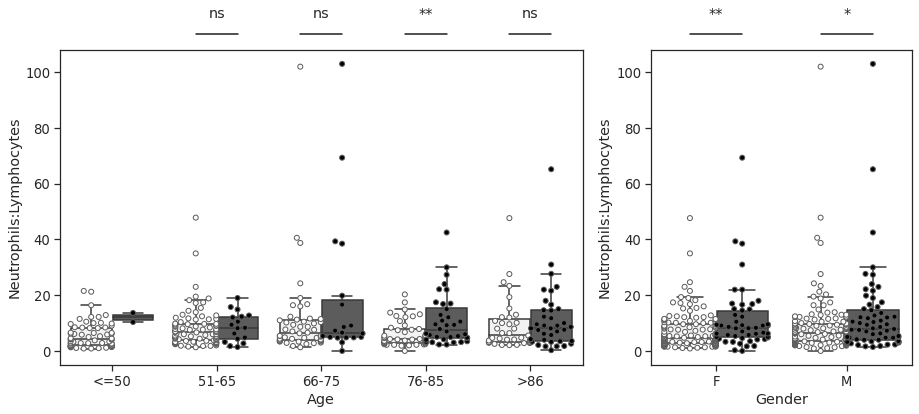

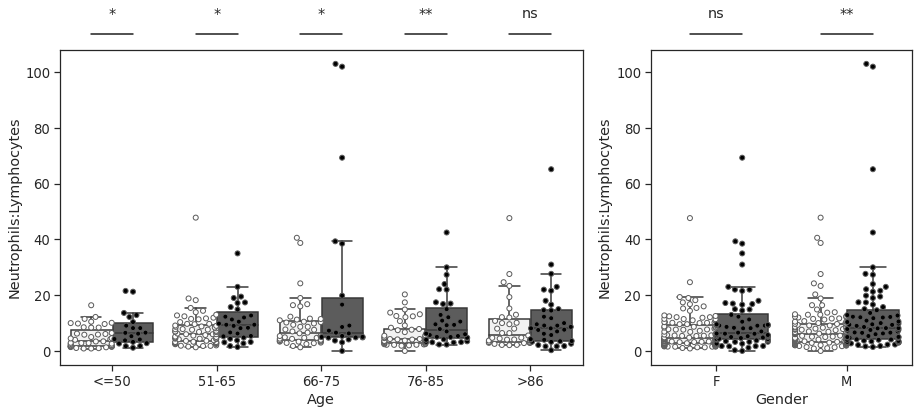

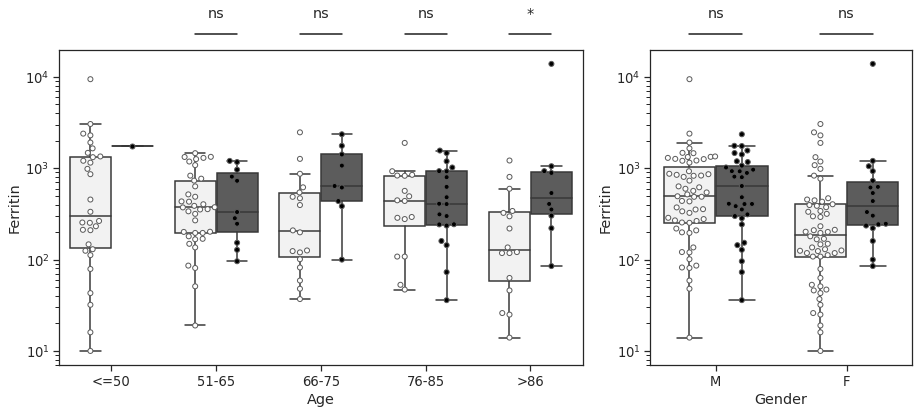

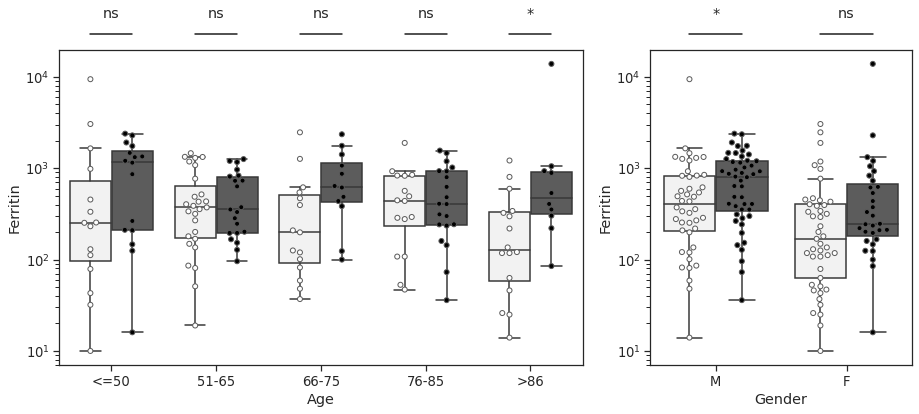

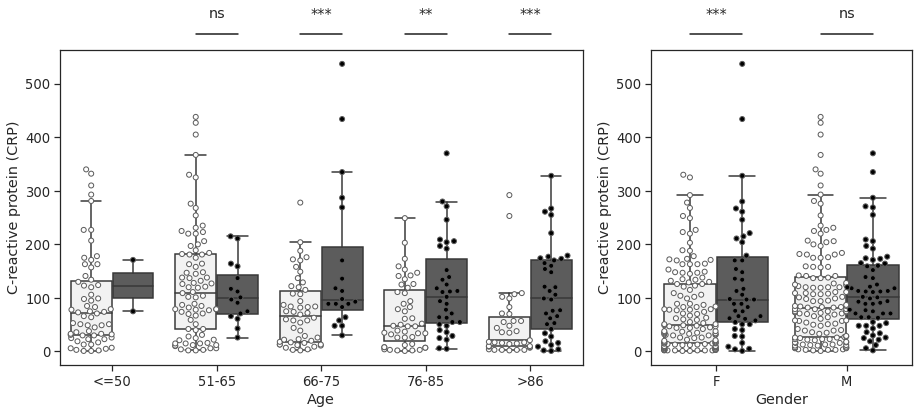

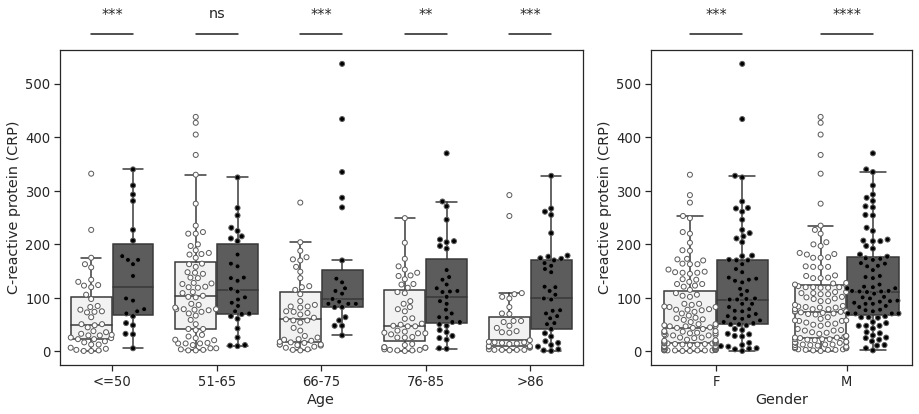

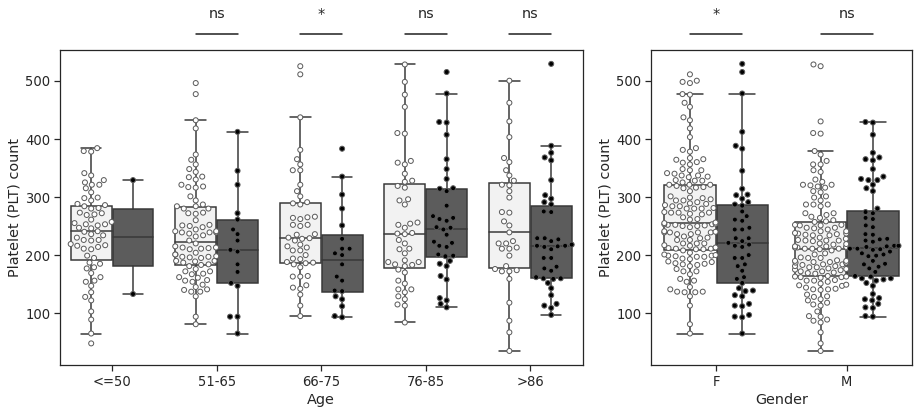

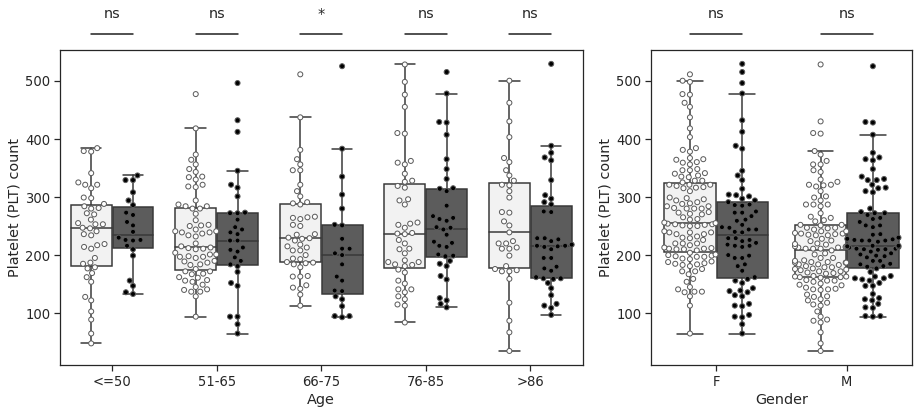

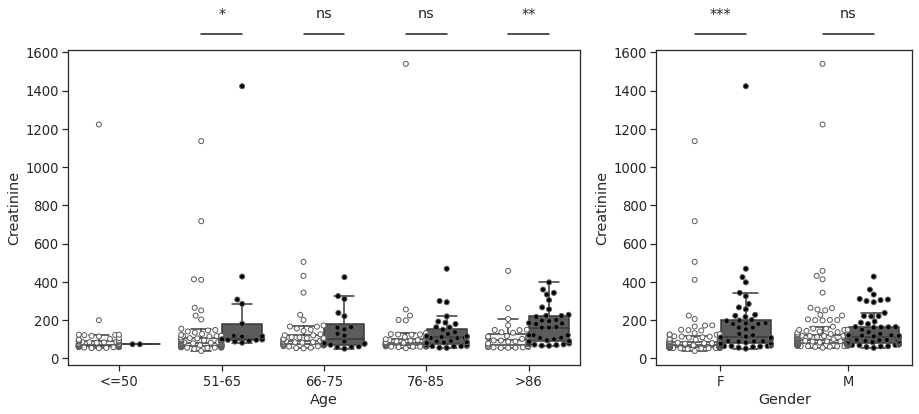

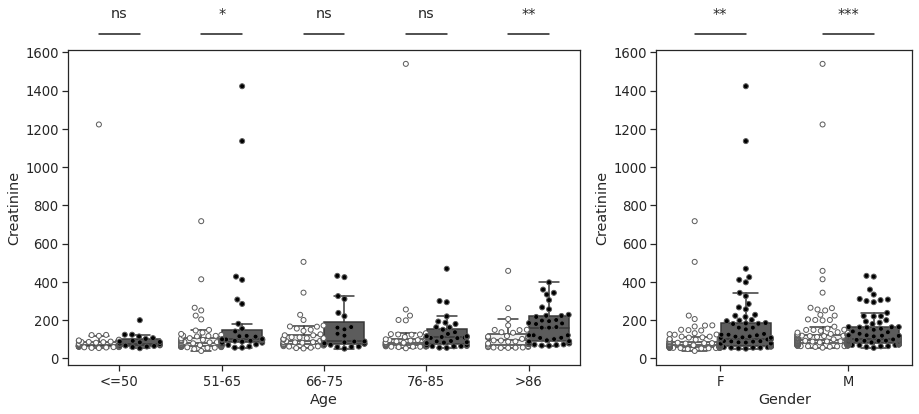

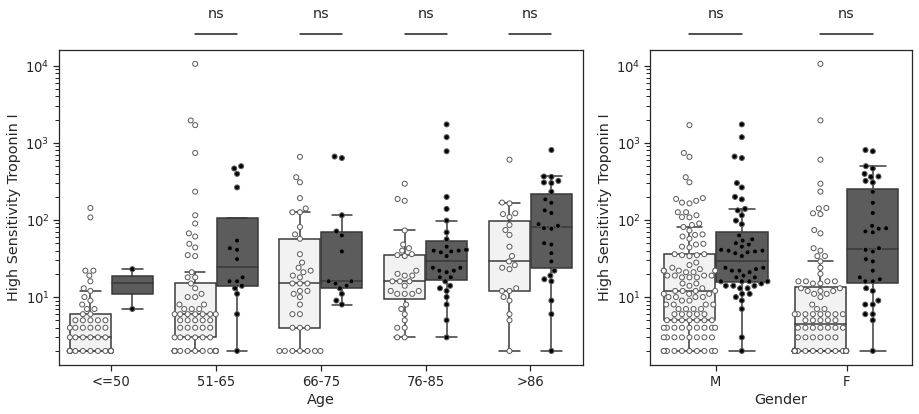

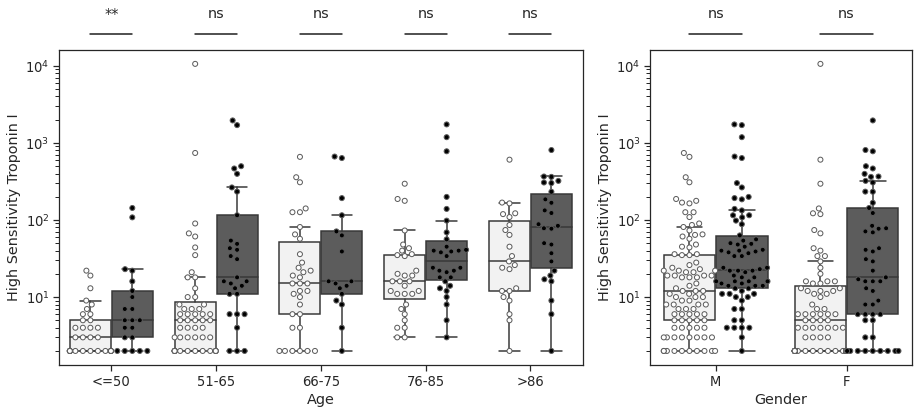

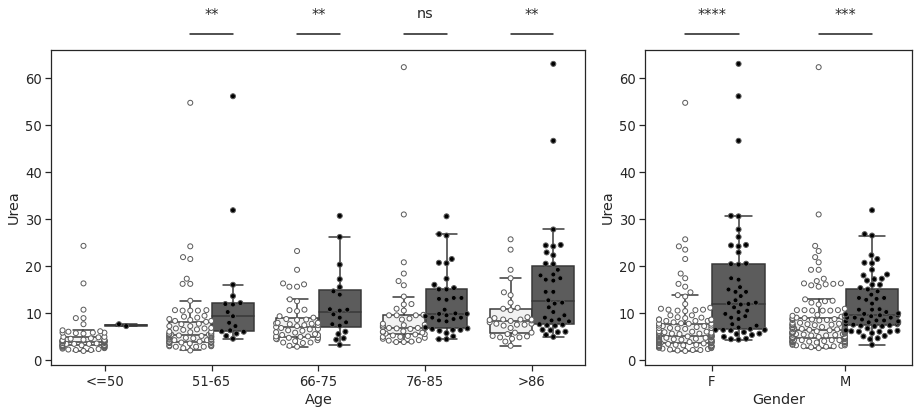

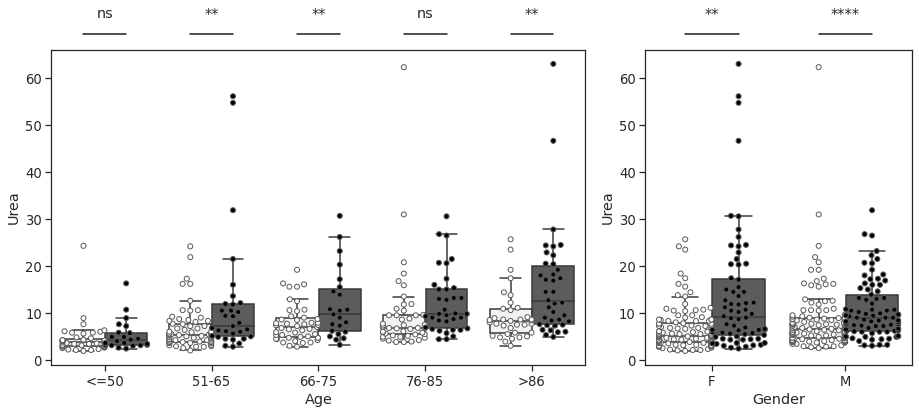

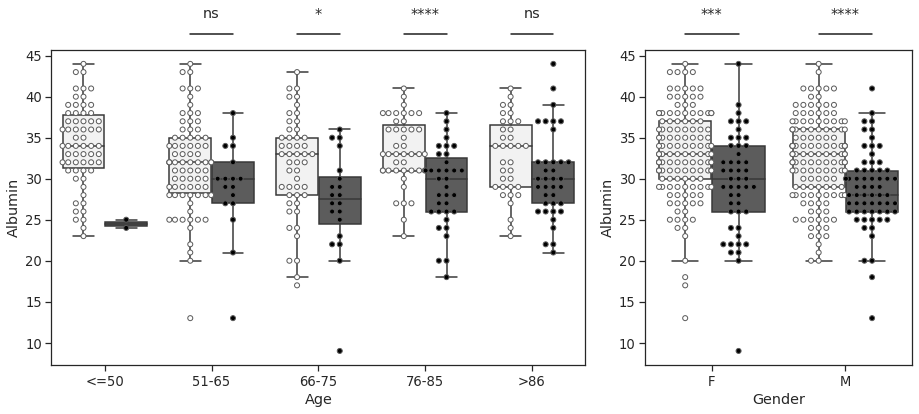

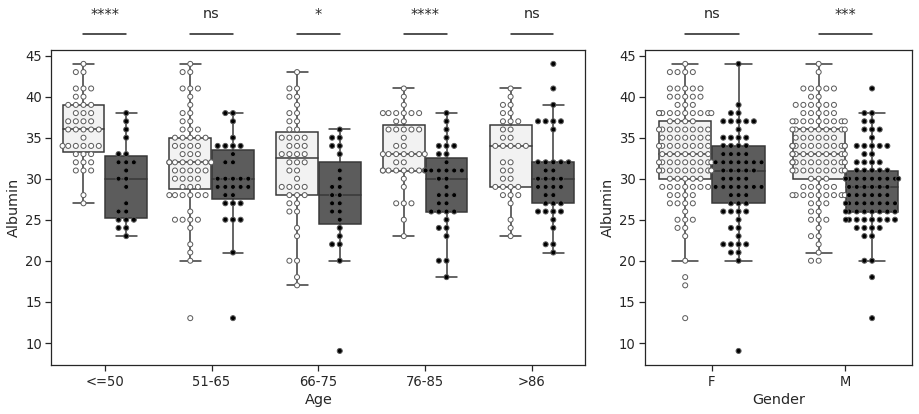

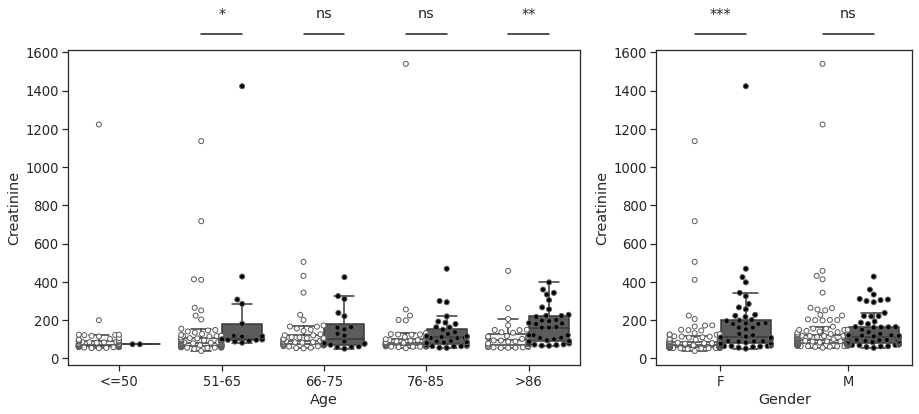

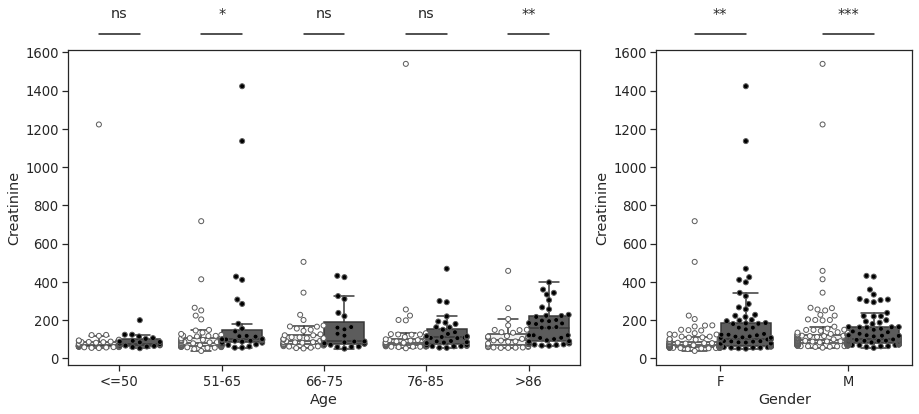

In [15]:
covid_admissions["age_groups"] = pd.Categorical(values=covid_admissions.age_groups,
                                                categories=["<=50", 
                                                            "51-65", "66-75", 
                                                            "76-85", ">86"])
log_scale_required = ["Procalcitonin", "Ferritin", "High Sensitivity Troponin I"]
for x in ["Procalcitonin", "D-dimer", "Lactate dehydrogenase",
          "Lymphocyte count", "Monocyte count", "Neutrophil count",
          "Neutrophils:Lymphocytes", "Ferritin",
          "C-reactive protein (CRP)", "Platelet (PLT) count",
          "Creatinine", "High Sensitivity Troponin I", "Urea", "Albumin", "Creatinine"]:
    log_scale = False
    if x in log_scale_required:
        log_scale = True
    box_swarm_facet(df=covid_admissions,
                    y=x,
                    fill="death",
                    log_scale=log_scale,
                    save=f"../figures/boxplots/{x}_mortality.svg")
    box_swarm_facet(df=covid_admissions,
                    y=x,
                    fill="composite",
                    log_scale=log_scale,
                    save=f"../figures/boxplots/{x}_mortality_icu.svg")

Below is just some code to create nice looking legends:

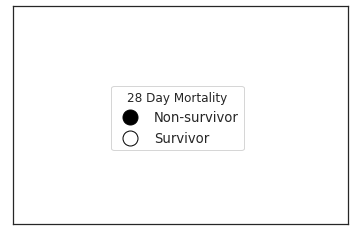

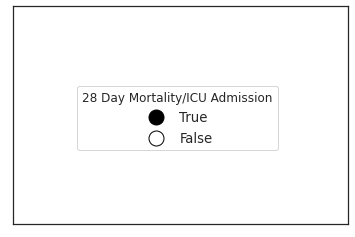

In [19]:
# Legend for 28 day mortality
handles = [Line2D([0], [0], marker='o', color='black', label='Scatter',
                 markerfacecolor='black', markersize=15, linestyle="None"),
          Line2D([0], [0], marker='o', color='black', label='Scatter',
                 markerfacecolor='white', markersize=15, linestyle="None")]
fig_legend = plt.figure()
axi = fig_legend.add_subplot(111)            
fig_legend.legend(handles, ["Non-survivor", "Survivor"], loc='center', scatterpoints = 1,
                  title="28 Day Mortality")
axi.xaxis.set_visible(False)
axi.yaxis.set_visible(False)
fig_legend.canvas.draw()
fig_legend.savefig("../figures/boxplots/mortality_legend.svg", facecolor="white")

# Legend for composite score
fig_legend = plt.figure()
axi = fig_legend.add_subplot(111)            
fig_legend.legend(handles, ["True", "False"], loc='center', scatterpoints = 1,
                  title="28 Day Mortality/ICU Admission")
axi.xaxis.set_visible(False)
axi.yaxis.set_visible(False)
fig_legend.canvas.draw()
fig_legend.savefig("../figures/boxplots/composite_legend.svg", facecolor="white")

<h1>How much 'missing data' is there? What variables can we compare between survivors and non-survivors?</h1>

Before we jump into predictive modeling, we want to take stock of the amount of 'missing' data. This is where tests do not overlap perfectly because the admission pathology performed on each patient is unique to their presentation in a way, however we can expect that at least some common tests are performed as standard.

Let's separate the data into survivors and non-survivors. We can then count the number of unique patients that each test is performed on at least once. From here we can determine the percentage of missing data per test and compare survivors to non-survivors.

In [37]:
survived = covid_admissions[covid_admissions.death == False].copy()
died = covid_admissions[covid_admissions.death == True].copy()

In [38]:
unique_tests = covid_admissions.test_name.unique()
counts = pd.DataFrame()
for label, df in zip([0, 1],[survived, died]):
    test_count = {x: len(df[df.test_name == x].patient_id.unique())
                for x in unique_tests}
    test_count = pd.DataFrame(test_count, index=[0]).melt(value_name="count", var_name="test_name")
    n = len(df.patient_id.unique())
    test_count["% missing"] = (n - test_count["count"])/n*100
    test_count["died"] = label
    counts = pd.concat([test_count, counts])

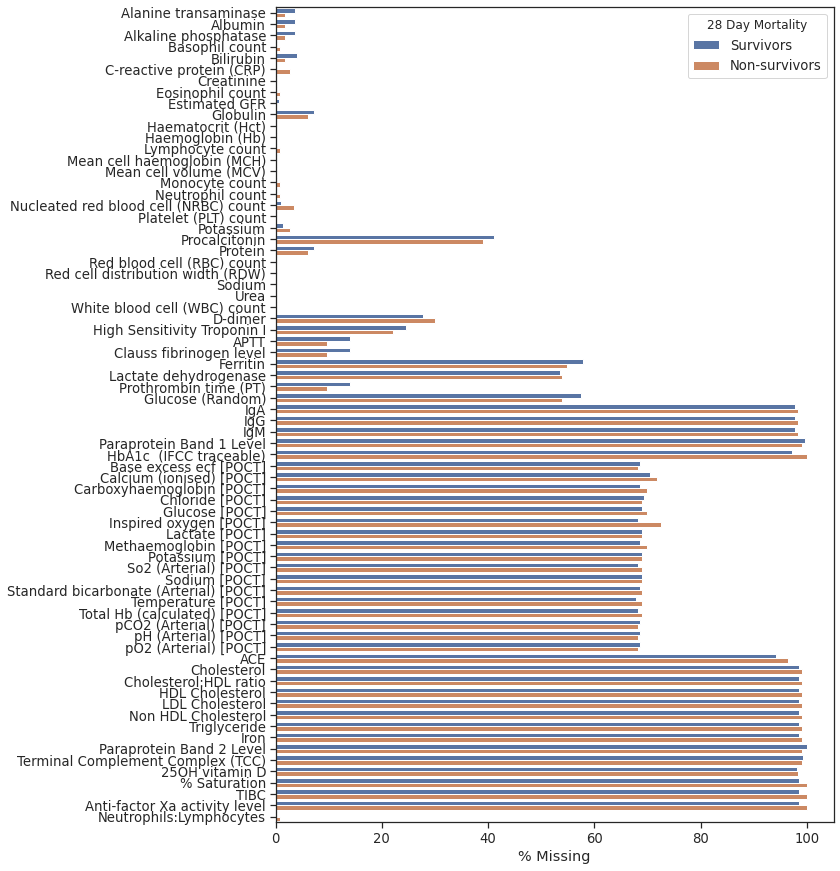

In [39]:
fig, ax = plt.subplots(figsize=(10, 15))
ax = sns.barplot(x="% missing", y="test_name", hue="died", data=counts, ci=None)
ax.set_xlabel("% Missing")
ax.set_ylabel("")
legend = ax.get_legend()
legend.set_title("28 Day Mortality")
legend.get_texts()[0].set_text('Survivors')
legend.get_texts()[1].set_text('Non-survivors')
fig.savefig("../figures/missing_data_perc.svg", facecolor="white", bbox_inches="tight")
plt.show()

This makes a lot of sense. Those more obscure tests as well as POCT that are reserved for severe conditions are less common in this dataset. We also see that there is a high degree of missing data for some of the tests that were brought in during the pandemic.

A reassuring sign is that there is a similar % of 'missingness' between survivors and non-survivors.

In [40]:
covid_admissions.groupby("patient_id").test_name.unique().apply(lambda x: len(x)).mean()

38.22051282051282

On average a patient would have one or more of 40 different tests performed within the first 48 hours of admission.

Let's take a look at those tests with less than 60% of missing values for all patients from the plots above.

In [41]:
tests = counts[counts["% missing"] <= 60].test_name.unique()
tests

array(['Alanine transaminase', 'Albumin', 'Alkaline phosphatase',
       'Basophil count', 'Bilirubin', 'C-reactive protein (CRP)',
       'Creatinine', 'Eosinophil count', 'Estimated GFR', 'Globulin',
       'Haematocrit (Hct)', 'Haemoglobin (Hb)', 'Lymphocyte count',
       'Mean cell haemoglobin (MCH)', 'Mean cell volume (MCV)',
       'Monocyte count', 'Neutrophil count',
       'Nucleated red blood cell (NRBC) count', 'Platelet (PLT) count',
       'Potassium', 'Procalcitonin', 'Protein',
       'Red blood cell (RBC) count', 'Red cell distribution width (RDW)',
       'Sodium', 'Urea', 'White blood cell (WBC) count', 'D-dimer',
       'High Sensitivity Troponin I', 'APTT', 'Clauss fibrinogen level',
       'Ferritin', 'Lactate dehydrogenase', 'Prothrombin time (PT)',
       'Glucose (Random)', 'Neutrophils:Lymphocytes'], dtype=object)

In order to get a better idea of the overlap it would be good to plot the actual test coverage per patient in a heatmap. Let's count how many patients recieve each test.

In [42]:
pts = covid_admissions.patient_id.unique()
overlap = pd.DataFrame(np.zeros((len(pts),len(tests)), dtype=np.int8), 
                       index=pts, columns=tests)
for t in tests:
    for p in pts:
        pt_data = covid_admissions[covid_admissions.patient_id == p]
        if t in pt_data.test_name.values:
            overlap.loc[p, t] = 1

In [43]:
overlap.sum().sort_values()

Ferritin                                 168
Glucose (Random)                         170
Lactate dehydrogenase                    181
Procalcitonin                            232
D-dimer                                  279
High Sensitivity Troponin I              297
Prothrombin time (PT)                    340
Clauss fibrinogen level                  340
APTT                                     340
Globulin                                 363
Protein                                  363
Bilirubin                                377
Alanine transaminase                     378
Albumin                                  378
Alkaline phosphatase                     378
Potassium                                383
Nucleated red blood cell (NRBC) count    383
C-reactive protein (CRP)                 387
Monocyte count                           388
Basophil count                           388
Eosinophil count                         388
Estimated GFR                            388
Neutrophil

/home/rossco/anaconda3/envs/CHAD/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


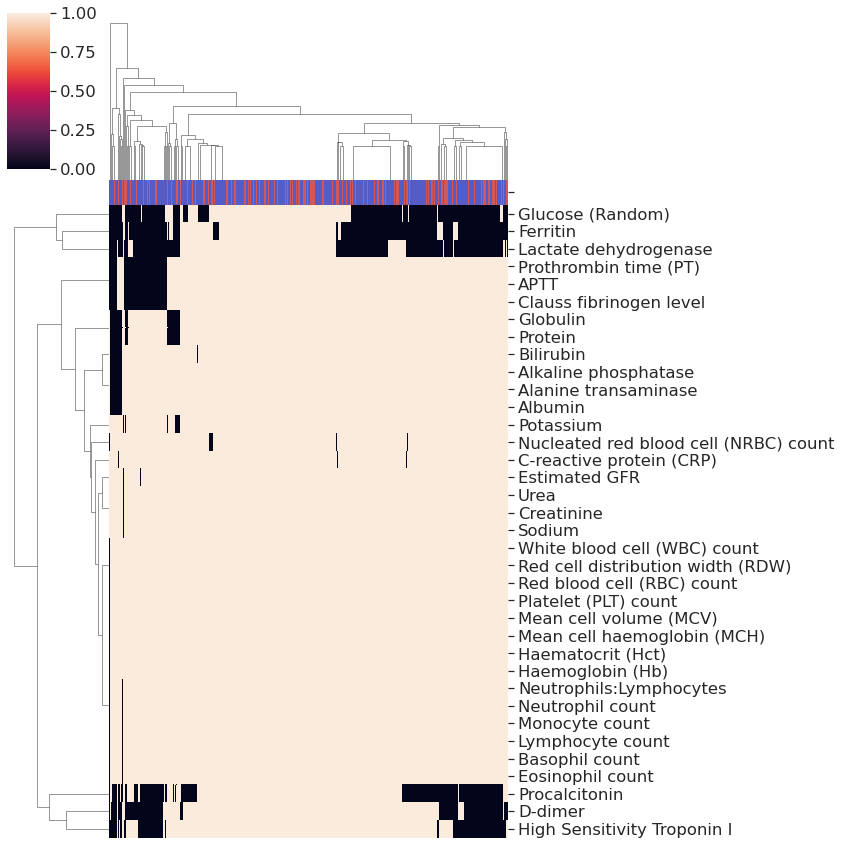

In [44]:
sns.set(style="white", font_scale=1.5)
covid_status = {pt_id: '#d15858' if died == 1 else '#545dc7' 
                for pt_id, died in zip(covid_admissions.patient_id.values, 
                                       covid_admissions.death.values)}
g = sns.clustermap(overlap.T, xticklabels=False, yticklabels=True,
               figsize=(12, 12), col_colors=pd.Series(covid_status))
g.savefig("../figures/missing_data_heatmap.svg", facecolor="white", bbox_inches="tight")

<h1>Assessing multicollinearity and feature selection prior to modeling</h1>

We know there is going to be correlations between many of the variables we have in our dataset, the obvious one being age and the many blood parameters captured. So we should assess the multicolinearity with a similarity matrix.

To reduce the amount of missing data we will only focus on the tests covered in the heatmap above. We also wish to reduce the complexity of any models we generate to reduce the risk of overfitting, so we should perform some preliminary feature selection that takes into account independent value of predictors, their observed variance, and correlation between variables. The clinical team has recommended the removal of the following to help reduce the complexity:

* RDW
* NRBC
* RBC count
* MCV
* Hct

At this stage we can produce a working dataset that is 'wide', meaning each variable is contained within its own column. We'll call this covid_mortality_predictors:

In [45]:
covid_admissions = pd.read_csv("../covid_admissions.csv")

In [46]:
remove = ['Haematocrit (Hct)',
          'Nucleated red blood cell (NRBC) count',
          'Red blood cell (RBC) count',
          'Mean cell volume (MCV)',
          'Red cell distribution width (RDW)']

tests = ['Alanine transaminase', 'Albumin', 'Alkaline phosphatase',
       'Basophil count', 'Bilirubin', 'C-reactive protein (CRP)',
       'Creatinine', 'Eosinophil count', 'Estimated GFR', 'Globulin',
       'Haematocrit (Hct)', 'Haemoglobin (Hb)', 'Lymphocyte count',
       'Mean cell haemoglobin (MCH)', 'Mean cell volume (MCV)',
       'Monocyte count', 'Neutrophil count', 'Neutrophils:Lymphocytes',
       'Nucleated red blood cell (NRBC) count', 'Platelet (PLT) count',
       'Potassium', 'Procalcitonin', 'Protein',
       'Red blood cell (RBC) count', 'Red cell distribution width (RDW)',
       'Sodium', 'Urea', 'White blood cell (WBC) count', 'D-dimer',
       'High Sensitivity Troponin I', 'APTT', 'Clauss fibrinogen level',
       'Ferritin', 'Lactate dehydrogenase', 'Prothrombin time (PT)',
       'Glucose (Random)']
tests = [x for x in tests if x not in remove]

In [47]:
covid_mortality_predictors = covid_admissions[["patient_id", 
                                               "test_name", 
                                               "test_result"]]
covid_mortality_predictors = (covid_mortality_predictors[covid_mortality_predictors
                                                         .test_name
                                                         .isin(tests)])

In [48]:
covid_mortality_predictors = covid_mortality_predictors.pivot(index="patient_id", 
                                                              columns="test_name", 
                                                              values="test_result")

In [49]:
demos = covid_admissions[["patient_id",
                         "age",
                         "gender",
                         "wimd",
                         "blood_group",
                         "death",
                         "critical_care",
                         "composite"]].drop_duplicates().set_index("patient_id")
covid_mortality_predictors = (covid_mortality_predictors
                              .merge(demos, 
                                     left_index=True, 
                                     right_index=True))

In [50]:
# Gender replaced with integer
covid_mortality_predictors["gender"] = (covid_mortality_predictors["gender"]
                                        .apply(lambda x: 1 if x == "F" else 0))

In [51]:
# Dummary variables for blood groups
pd.get_dummies(covid_mortality_predictors.blood_group, 
               dummy_na=True,
               prefix="BloodGroup").head()
abg_dummies = pd.get_dummies(covid_mortality_predictors.blood_group, 
               dummy_na=True,
               prefix="BloodGroup")
covid_mortality_predictors = covid_mortality_predictors.merge(abg_dummies, 
                                                              left_index=True, 
                                                              right_index=True)
covid_mortality_predictors.drop("blood_group", axis=1, inplace=True)
covid_mortality_predictors.head(3)

APTT  Alanine transaminase  Albumin  Alkaline phosphatase  \
patient_id                                                              
10090271     NaN                  10.0     33.0                  72.0   
10090361     NaN                  32.0     33.0                  75.0   
10090870    33.9                   9.0     28.0                 130.0   

            Basophil count  Bilirubin  C-reactive protein (CRP)  \
patient_id                                                        
10090271               0.0        5.0                     106.0   
10090361               0.0        6.0                      50.0   
10090870               0.0        8.0                     109.0   

            Clauss fibrinogen level  Creatinine  D-dimer  ...  gender    wimd  \
patient_id                                                ...                   
10090271                        NaN        60.0      NaN  ...       1   144.0   
10090361                        NaN        95.0    628.0  ...       0   467.0   
10090870                        4.3       262.0   1828.0  ...       0  1366.0   

            death  critical_care  composite  BloodGroup_A  BloodGroup_AB  \
patient_id                                                                 
10090271    False          False      False             1              0   
10090361    False          False      False             0              0   
10090870    False          False      False             0              0   

            BloodGroup_B  BloodGroup_O  BloodGroup_nan  
patient_id                                              
10090271               0             0               0  
10090361               0             0               1  
10090870               0             1               0  

[3 rows x 42 columns]

Convert the wimd into a binary variable of <1000 or >= 1000:

In [52]:
covid_mortality_predictors["wimd"] = (covid_mortality_predictors["wimd"]
                                      .apply(lambda x: 0 if x < 1000 else 1))

In [36]:
covid_mortality_predictors.reset_index().to_csv("../covid_mortality_predictors.csv", index=False)

<h2>Spearman-rank correlation matrix</h2>

In [53]:
covid_mortality_predictors = pd.read_csv("../covid_mortality_predictors.csv")

In [54]:
cont_features = ['APTT', 'Alanine transaminase', 'Albumin', 'Alkaline phosphatase',
       'Basophil count', 'Bilirubin', 'C-reactive protein (CRP)',
       'Clauss fibrinogen level', 'Creatinine', 'D-dimer', 'Eosinophil count',
       'Estimated GFR', 'Ferritin', 'Globulin', 'Haemoglobin (Hb)',
       'High Sensitivity Troponin I', 'Lactate dehydrogenase',
       'Lymphocyte count', 'Mean cell haemoglobin (MCH)', 'Monocyte count',
       'Neutrophil count','Neutrophils:Lymphocytes', 'Platelet (PLT) count', 'Potassium',
       'Procalcitonin', 'Protein', 'Prothrombin time (PT)', 'Sodium', 'Urea',
       'White blood cell (WBC) count', 'age']

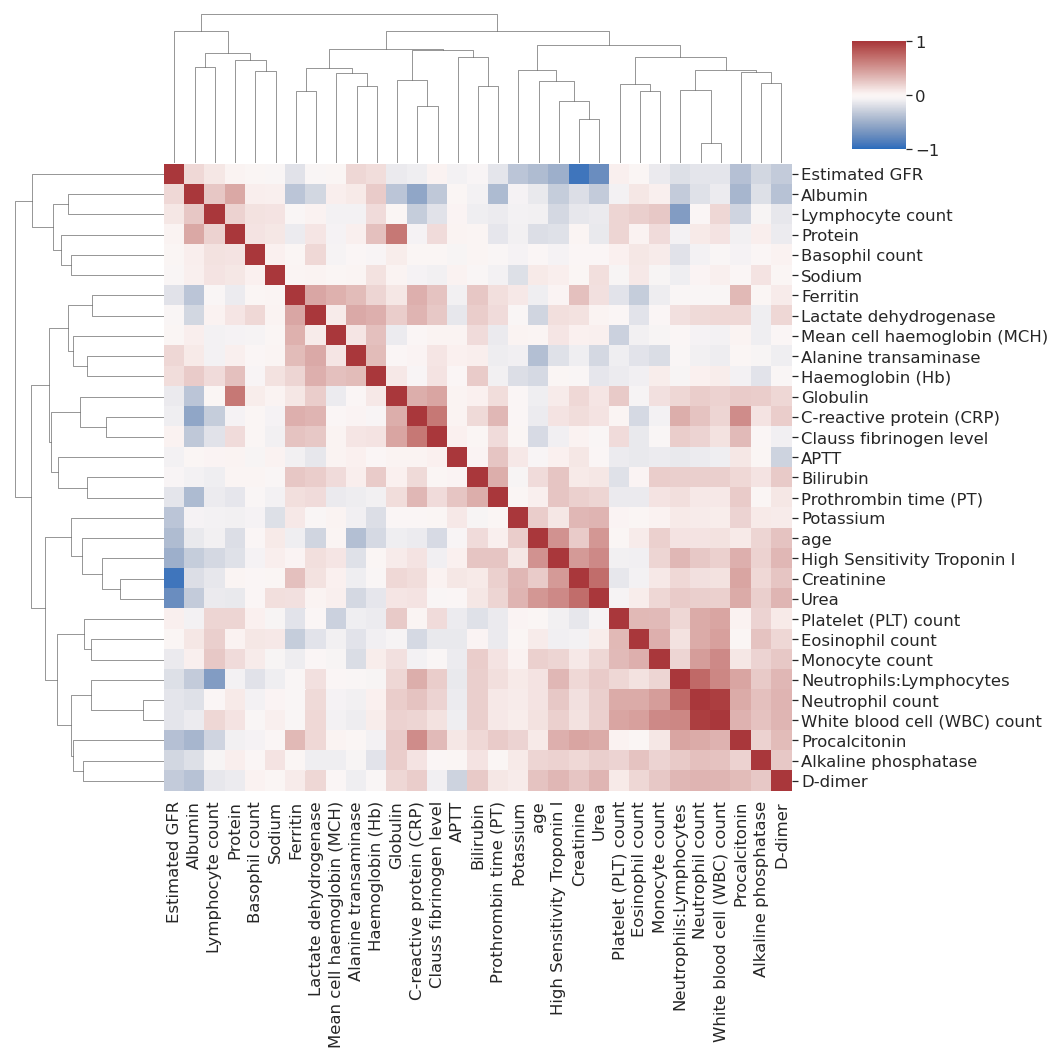

In [55]:
corr = covid_mortality_predictors[cont_features].corr(method="spearman")
g = sns.clustermap(corr, 
                  figsize=(15, 15), 
                  xticklabels=True,
                  yticklabels=True,
                  cmap="vlag",
                  vmin=-1.,
                  vmax=1.,
                  cbar_pos=(0.8, 0.85, 0.05, 0.1))
g.savefig("../figures/corr_matrix.svg", facecolor="white", bbox_inches="tight")
plt.show()

<h2>Rank by variance</h2>

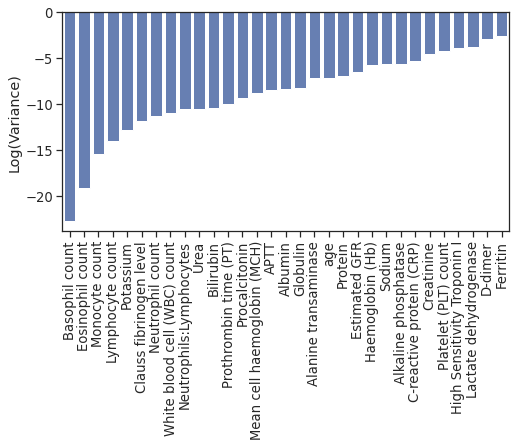

In [40]:
from sklearn.preprocessing import Normalizer
fig, ax = plt.subplots(figsize=(8, 8))
df = pd.DataFrame(Normalizer().fit_transform(covid_mortality_predictors[cont_features].dropna()),
                  columns=cont_features)
x = pd.DataFrame(np.log(df[cont_features].var()).sort_values(), 
                 columns=["Log(Variance)"])
sns.barplot(x=x.index, y=x["Log(Variance)"], ax=ax, color="#5a7abf")
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
plt.gcf().subplots_adjust(bottom=0.5)
plt.savefig("../figures/variance.svg", facecolor="white", bbox_inches="tight")
plt.show()

<h2>Rank by independent p-value and effect size</h2>

In [5]:
mortality_feature_ranks = feature_scores(covid_mortality_predictors, 
                                         cont_features, 
                                         "death")
mortality_icu_feature_ranks = feature_scores(covid_mortality_predictors, 
                                             cont_features, 
                                             "composite")

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Independent p-values; 28 Day Mortality (Survivors vs Non-Survivors)'}, ylabel='-Log(p-value)'>)

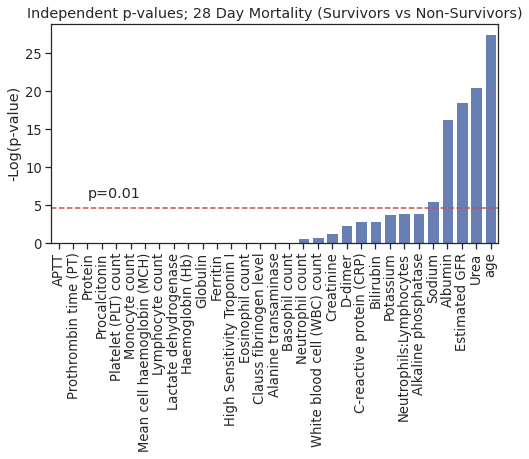

In [6]:
plot_pvals(mortality_feature_ranks,
           "Independent p-values; 28 Day Mortality (Survivors vs Non-Survivors)",
           save="../figures/rank_pvals_mortality.svg")

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Independent p-values; 28 Day Mortality/ICU Admission'}, ylabel='-Log(p-value)'>)

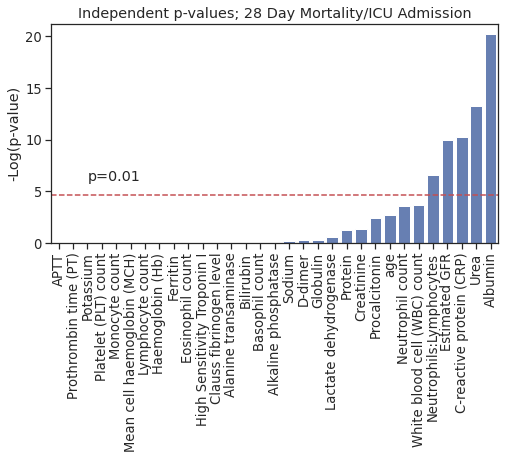

In [7]:
plot_pvals(mortality_icu_feature_ranks, 
           "Independent p-values; 28 Day Mortality/ICU Admission",
           save="../figures/rank_pvals_composite.svg")

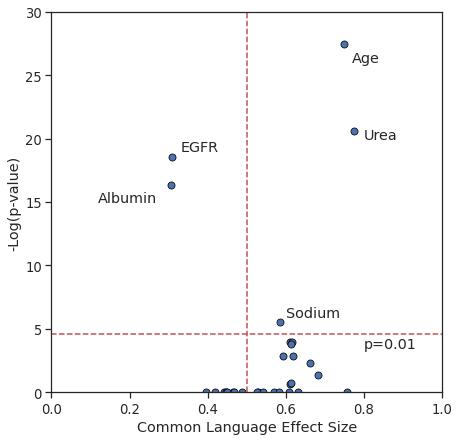

In [33]:
df = mortality_feature_ranks.copy()
df["-Log(p-value)"] = -np.log(df["p-values"])
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.scatterplot(x="effect size", y="-Log(p-value)", 
                     data=df, s=50, lw=3, edgecolor="black",
                     ax=ax)
ax.set_xlim(0, 1)
ax.set_ylim(0, 30)
ax.set_xlabel("Common Language Effect Size")
ax.annotate(xy=(0.8, 3.5), text="p=0.01")
ax.annotate(xy=(0.8, 20), text="Urea")
ax.annotate(xy=(0.77, 26), text="Age")
ax.annotate(xy=(0.33, 19), text="EGFR")
ax.annotate(xy=(0.12, 15), text="Albumin")
ax.annotate(xy=(0.6, 5.9), text="Sodium")
#ax.annotate('', xy=(0.6, 3.9), xytext=(0.3, 5),xycoords='data',
#            arrowprops=dict(arrowstyle="->", color='black'))
#ax.annotate(xy=(0.2, 4.1), text="ALP")
ax.axvline(x=0.5, ls="--", c="r")
ax.axhline(y=-np.log(0.01), ls="--", c="r")
fig.savefig("../figures/mortality_pval_effectsize.svg", facecolor="white")
plt.show()

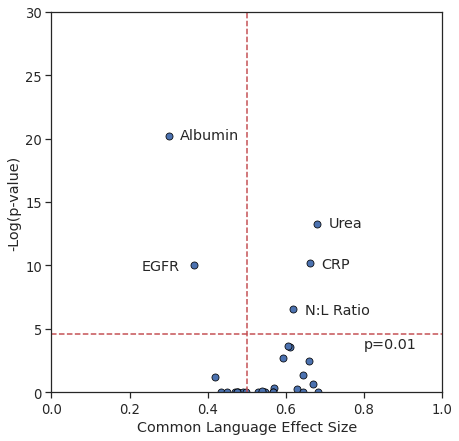

In [9]:
df = mortality_icu_feature_ranks.copy()
df["-Log(p-value)"] = -np.log(df["p-values"])
fig, ax = plt.subplots(figsize=(7,7))
ax = sns.scatterplot(x="effect size", y="-Log(p-value)", 
                     data=df, s=50, lw=3, edgecolor="black",
                     ax=ax)
ax.set_xlim(0, 1)
ax.set_ylim(0, 30)
ax.set_xlabel("Common Language Effect Size")
ax.annotate(xy=(0.8, 3.5), text="p=0.01")
ax.annotate(xy=(0.69, 9.8), text="CRP")
ax.annotate(xy=(0.71, 13), text="Urea")
ax.annotate(xy=(0.33, 20), text="Albumin")
ax.annotate(xy=(0.23, 9.6), text="EGFR")
ax.annotate(xy=(0.65, 6.2), text="N:L Ratio")
ax.axvline(x=0.5, ls="--", c="r")
ax.axhline(y=-np.log(0.05), ls="--", c="r")
fig.savefig("../figures/composite_pval_effectsize.svg", facecolor="white")
plt.show()

<h2>Fishers exact test for categorical variables</h2>

In [4]:
fishers("gender", (covid_admissions[["patient_id", "gender", "death"]]
                .drop_duplicates()
                .drop("patient_id", axis=1)), "death")

0.3147289149447428

In [6]:
fishers("gender", (covid_admissions[["patient_id", "gender", "composite"]]
                .drop_duplicates()
                .drop("patient_id", axis=1)),
       "composite")

0.4679339342358053

In [7]:
fishers("blood_group", (covid_admissions[["patient_id", "blood_group", "death"]]
                .drop_duplicates()
                .drop("patient_id", axis=1)),
     "death")

0.8906665658102823

In [8]:
fishers("blood_group", (covid_admissions[["patient_id", "blood_group", "composite"]]
                .drop_duplicates()
                .drop("patient_id", axis=1)),
     "composite")

0.7326661274069997

<h2>Which features should we retain for multivariate models?</h2>

Age, gender, and WIMD will be included in all multivariate models to account for possible confounding effects, but for all other features, we must narrow down to those most suitable for inclusion into a final model as to reduce complexity and the risk of overfitting.

**Variance**

The following features have very low variability and can be dismissed from multivariate models as they will unlikely contribute to an accurate prediction of an endpoint:
* Basophil count
* Eosinophil count
* Potassium
* Monocyte count
* Lymphocyte count

We should note that we observe high variability for D-dimer, Ferritin, Troponin, ALT, and LDH.

**Independent p-value and effect size**

For the two different end-points the following features exhibited a significant p-value (<= 0.01) after accounting for multiple comparisons, those in bold also showed an absolute effect size greater than 0.5:

28 day mortality:
* **Urea**
* **EGFR**
* **Albumin**

28 day mortality/ICU admission:
* **Urea**
* **Albumin**
* **CRP**
* **Neutrophils:Lymphocytes**
* **EGFR**

**Categorical variables**

The only categorical variable other than gender was blood type, for which the proportion of observed True/False values (for each given endpoint) for each category did not significantly differ from the expected proportions to accept the null hypothesis, when using chi-squared test for independence. We therefore cannot say that blood group is significantly different between survivors/non-survivors and/or severity of disease.

**Accounting for multicolinearity**

There is a lot of overlap for the two different endpoints, so we can form a list of features that we use for both. Since we have applied quite a strict feature selection process, only accepting those with an independent p-value less than or equal to 0.01, we have reduced the feature space enough that most of this multicolinearity is accounted for. 

A variable that does occur in our selection is EGFR. This is a calculated score for age, gender, and creatinine so it makes sense that we see high colinearity between these variables. This can create issues with convergence so we will drop EGFR for creatinine.

**Features for predictive models**

This leaves us with the following features to be retained, not including the extended COVID-19 panel, which will be included in multivariate models to assess their benefit:

* Age
* Gender
* WIMD
* Creatinine
* Neutrophils:Lymphocytes
* CRP
* Albumin
* Urea